In [1]:
import mnist_input
import mnist_model
reload(mnist_model)
import numpy as np
import tensorflow as tf
import mnist_util
reload(mnist_util)
mnist = mnist_input.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
import pickle
with open("/home/justin/Programming/AdverserialMNIST/saved_models/l1reg_C20000_results.pkl", "rb") as pkl_file:
    df_l1 = pickle.load(pkl_file)
with open("/home/justin/Programming/AdverserialMNIST/saved_models/baseline_results.pkl", "rb") as pkl_file:
    df_baseline = pickle.load(pkl_file)

In [5]:
df_l1["Fooling Image (Y/N)"] = df_l1.apply(lambda row: row["Predicted Label"] != row["Predicted Label Adverserial"],
                                     axis = 1)
print sum(df_l1["Fooling Image (Y/N)"]), df_l1["Gradient Norm"].isnull().sum()
df_baseline["Fooling Image (Y/N)"] = df_baseline.apply(lambda row: row["Predicted Label"] != row["Predicted Label Adverserial"],
                                     axis = 1)
print sum(df_baseline["Fooling Image (Y/N)"]), df_baseline["Gradient Norm"].isnull().sum()


43008 17670
16902 0


In [4]:
df_baseline.columns.values

array(['Adverserial Image', 'Gradient', 'Gradient Norm', 'Gradient Step',
       'Idx', 'Image', 'Predicted Label', 'Predicted Label Adverserial',
       'Predicted Probs', 'Predicted Probs Adverserial', 'True Label'], dtype=object)

In [7]:
df_l1["Gradient Norm"].describe()

count    8.233000e+04
mean     1.191469e+01
std      1.181663e+02
min      2.472408e-27
25%      7.834946e-17
50%      5.449561e-13
75%      2.828740e-09
max      2.171526e+03
Name: Gradient Norm, dtype: float64

In [6]:
df_baseline["Gradient Norm"].describe()

count    1.000000e+05
mean     2.860211e+00
std      2.359283e+01
min      2.721991e-14
25%      8.332103e-07
50%      5.449513e-05
75%      1.730353e-03
max      3.747029e+02
Name: Gradient Norm, dtype: float64

In [20]:
null_grads = df_l1[df_l1["Gradient Norm"].isnull()]
null_grads["True Label"].value_counts()

4    4700
8    2870
3    2560
2    2490
6    1750
5    1460
9    1200
7     630
0      10
Name: True Label, dtype: int64

In [8]:
grouped = df_l1.groupby("Gradient Step")["Fooling Image (Y/N)"].aggregate([np.mean, np.sum])
grouped

,mean,sum
Gradient Step,,
0.01,0.1962,1962
0.02,0.2319,2319
0.03,0.2814,2814
0.04,0.3405,3405
0.05,0.4078,4078
0.06,0.4711,4711
0.07,0.5279,5279
0.08,0.5778,5778
0.09,0.6166,6166


In [10]:
grouped = df_baseline.groupby("Gradient Step")["Fooling Image (Y/N)"].aggregate([np.mean, np.sum])
grouped

,mean,sum
Gradient Step,,
0.01,0.0090,90
0.02,0.0230,230
0.03,0.0405,405
0.04,0.0705,705
0.05,0.1120,1120
0.06,0.1619,1619
0.07,0.2221,2221
0.08,0.2913,2913
0.09,0.3516,3516


In [21]:
bad_samples_l1 = df_l1[df_l1.apply(lambda row: row["Predicted Label"] != \
                          row["Predicted Label Adverserial"], axis = 1)].dropna(subset = ["Gradient Norm"])
print len(bad_samples_l1)
bad_samples_baseline = df_baseline[df_baseline.apply(lambda row: row["Predicted Label"] != \
                          row["Predicted Label Adverserial"], axis = 1)].dropna(subset = ["Gradient Norm"])
print len(bad_samples_baseline)

25338
16902


In [22]:
bad_samples_baseline["True Label"].value_counts()

9    3628
8    2099
7    2055
2    1815
5    1659
3    1579
4    1500
6    1020
0     929
1     618
Name: True Label, dtype: int64

In [19]:
bad_samples_l1[["True Label", "Predicted Label", "Predicted Label Adverserial",\
                               "Gradient Norm"]][:10]

,True Label,Predicted Label,Predicted Label Adverserial,Gradient Norm
22,1,1,4,1.346662e-11
23,1,1,4,1.346662e-11
24,1,1,4,1.346662e-11
25,1,1,4,1.346662e-11
26,1,1,4,1.346662e-11
27,1,1,4,1.346662e-11
28,1,1,4,1.346662e-11
29,1,1,4,1.346662e-11
61,4,4,9,2.889365e-10
62,4,4,9,2.889365e-10


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

Predicted: 6


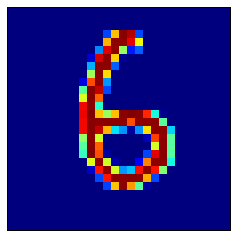

Predicted Adverserial: 5


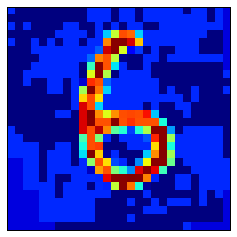

In [15]:
idx = 40
row = bad_samples.iloc[idx]
img1 = row["Image"]
img2 = row["Adverserial Image"]
print "Predicted: %d" %row["Predicted Label"]
mnist_util.plot_mnist_digit(np.reshape(img1, [28,28]))

print "Predicted Adverserial: %d" %row["Predicted Label Adverserial"]
mnist_util.plot_mnist_digit(np.reshape(img2, [28,28]))

In [34]:
bad_samples_baseline["Gradient Step"].value_counts()

0.10    4083
0.09    3516
0.08    2913
0.07    2221
0.06    1619
0.05    1120
0.04     705
0.03     405
0.02     230
0.01      90
Name: Gradient Step, dtype: int64

2221
1741264
2.08709 -2.1991


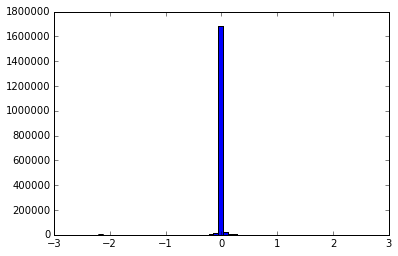

In [47]:
#plot histogram of the partials
subset = bad_samples_baseline[bad_samples_baseline["Gradient Step"] == .07]
print len(subset)
all_partials = []
for grad in subset["Gradient"].values:
    all_partials.extend(grad[0])
print len(all_partials)
print max(all_partials), min(all_partials)
plot = plt.hist(all_partials, bins = 50)

3512
2753408
8.38758 -11.9846


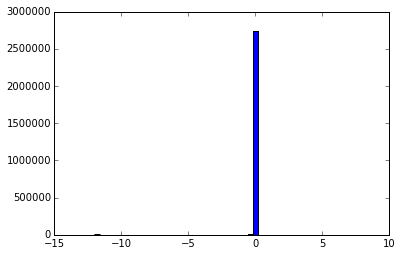

In [48]:
#plot histogram of the partials
subset = bad_samples_l1[bad_samples_l1["Gradient Step"] == .07]
print len(subset)
all_partials = []
for grad in subset["Gradient"].values:
    all_partials.extend(grad[0])
print len(all_partials)
print max(all_partials), min(all_partials)
plot = plt.hist(all_partials, bins = 50)

In [60]:
print sum(df_baseline["Gradient Norm"] < .00001), sum(df_l1["Gradient Norm"] < .00001)

40950 74930


In [59]:
sum(df_l1["Gradient Norm"].isnull())

17670

In [ ]:
img = 